In [2]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import cmocean.cm as cmo

setup = "ESII_SO"
confi = "RCSI100.L55_ctlv30_030W"

## __[ESII_SO-RCSI100.L55_ctlv30_030W](https://github.com/jk-rieck/MITgcm_configs/tree/narval/ESII_SO/RCSI100.L55_ctlv30_030W)__
is a reentrant channel configuration of the [MITgcm](https://mitgcm.readthedocs.io/en/latest/) with a bathymetry resembling the Southern Ocean at a horizontal resolution of __`10.0 km`__ with __`55` vertical levels__.   

---

### __Vertical grid__

The vertical axis is build based on [Stewart et al. (2017)](https://www.sciencedirect.com/science/article/abs/pii/S1463500317300434) ([this script](https://github.com/kialstewart/vertical_grid_for_ocean_models/blob/master/build_vertical_grid_kds.py)) in this [Notebook](MITgcm_config/ESII_SO/RCSI100.L55_ctlv30_030W/input/construct_vertical_grid.ipynb). 

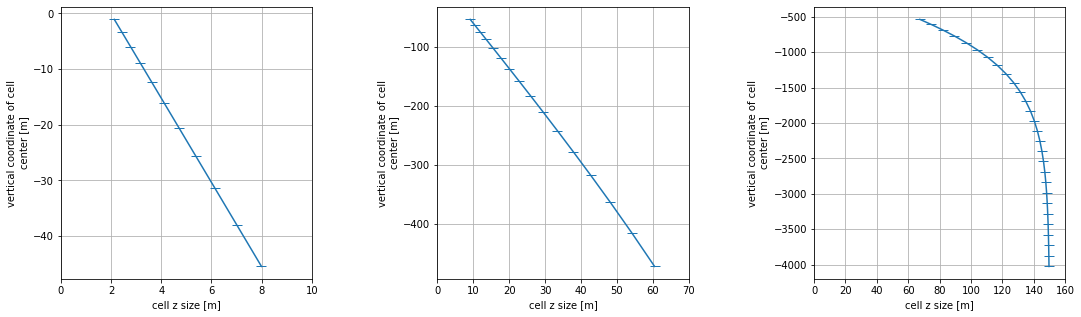

In [4]:
vert_ax = xr.open_dataset("MITgcm_config/" + setup + "/" + confi + "/input/" 
                          + setup + "-" + confi + "-vertical_grid.nc")
fig, axes = plt.subplots(figsize=(18, 5), ncols=3)
vert_ax.drF.sel(Z=slice(0, -50)).plot.line("-_", ax=axes[0], y="Z", markersize=10)
axes[0].set_xlim(0, 10)
axes[0].grid()
vert_ax.drF.sel(Z=slice(-50, -500)).plot.line("-_", ax=axes[1], y="Z", markersize=10)
axes[1].set_xlim(0, 70)
axes[1].grid()
vert_ax.drF.sel(Z=slice(-500, -5000)).plot.line("-_", ax=axes[2], y="Z", markersize=10)
axes[2].set_xlim(0, 160)
axes[2].grid()
plt.subplots_adjust(wspace=0.5)

*Fig. 1: Cell thickness as a function of vertical coordinate of the cell center for the vertical axis used in the configuration. Note the different x-axes on the subplots.*

---

### __Bathymetry__

The bathymetry is a flat bottom with a shelf at the southern boundary, similar to many setups before (e.g. [Doddridge et al. (2019)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL082758), [Gupta et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020JC016404)). The bathymetry is build as described in this [Notebook](MITgcm_config/ESII_SO/RCSI100.L55_ctlv30_030W/input/create_bathymetry.ipynb) with the chosen parameters listed in the following table:  

| domain            | shelf             |
| :-                | :-                |
| x_num_cells = 240 | add shelf = True  |
| y_num_cells = 320 | depth = 300       |
| dx = 10           | slope pos. = 400  |
| dy = 10           | slope width = 120 |
| add wall S = True |                   |

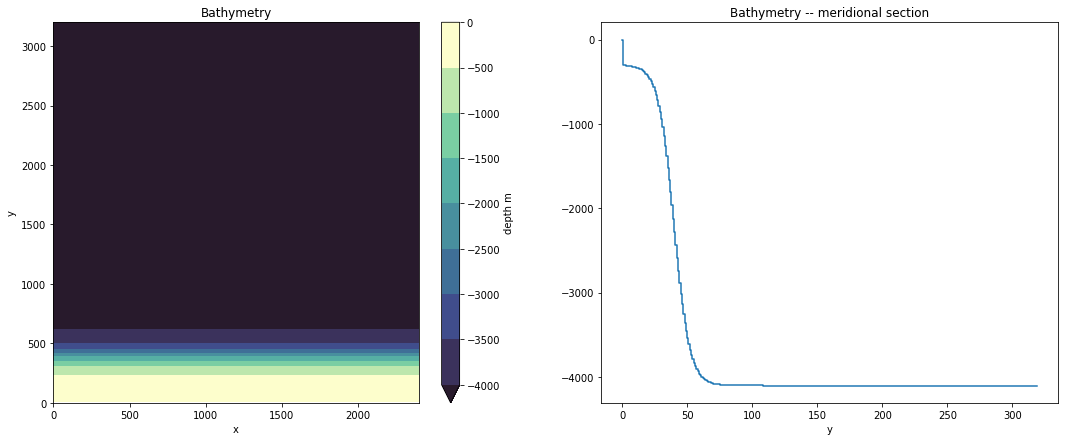

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 7))

bathy = xr.open_dataset("MITgcm_config/" + setup + "/" + confi + "/input/" 
                        + setup + "-" + confi + "-bathymetry_and_mask.nc")

levels = np.arange(-4000, 1, 500)
bathy.bathy.plot(levels=levels, cmap=cmo.deep_r, cbar_kwargs={'label': 'depth m'}, ax=axs[0])
axs[0].set_title("Bathymetry")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

axs[1].step(np.arange(0, len(bathy.y)), bathy.bathy[:,0], where="post")
axs[1].set_title("Bathymetry -- meridional section")
axs[1].set_xlabel("y");

*Fig. 2: The bathymetry used in the configuration*

---

### __Compiled packages__

The configuration uses the RBCS package to apply restoring at the northern boundary, the KPP package to parameterize vertical mixing, the EXF package to force the ocean, and the SEAICE package to simulate sea ice, as well as SALT_PLUME to improve the impact of brine rejection. Additionally, the LAYERS package is used to compute transport on isopycnal layers online. Note that the THSICE package is compiled but not used in the simulation (i.e. `useTHSICE=.FALSE.` in `data.pkg`)

In [7]:
!cat MITgcm_config/ESII_SO/RCSI100.L55_ctlv30_030W/code/packages.conf

#-- list of packages (or group of packages) to compile for this experiment:
gfd
rbcs
diagnostics
kpp
exf
cal
seaice
thsice
layers
salt_plume


The following files need to be modified and present in the `code` directory:  

In [8]:
!ls MITgcm_config/ESII_SO/RCSI100.L55_ctlv30_030W/code/

CPP_OPTIONS.h	    GAD_OPTIONS.h     LAYERS_SIZE.h	 SEAICE_OPTIONS.h
DIAGNOSTICS_SIZE.h  KPP_OPTIONS.h     packages.conf	 SEAICE_SIZE.h
EXF_OPTIONS.h	    LAYERS_OPTIONS.h  PACKAGES_CONFIG.h  SIZE.h


 
Please have a look at the files directly [here](https://github.com/jk-rieck/2024-eddy-heat-transport-towards-sea-ice/tree/main/MITgcm_config/ESII_SO/RCSI100.L55_ctlv30_030W/code) for more details.  

---

### __Initial Conditions and Restoring__

The initial conditions for temperature ([Locarnini et al (2019)](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-WOA18)) and salinity ([Zweng et al (2019)](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-WOA18)) are taken from the World Ocean Atlas 2018 ([WOA18](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-WOA18), [Boyer et al. (2018)](https://www.ncei.noaa.gov/archive/accession/NCEI-WOA18)) monthly mean climatology for the years 1981-2010 (`decav81B0`). A zonal sections is extracted at $30 ^{\circ} W$ and is interpolated to $j$ evenly spaced locations between $75 ^{\circ} S$ and $35 ^{\circ} S$ at every depth level of the vertical grid and then repeated $i$ times in the $x$-direction, where $i$ and $j$ are the number of grid cells in the $x$- and $y$-direction, respectively, such that the resulting initial conditions are zonally constant. Below `1500` m, seaonal mean climatlogical values are used (because there is no monthly climatology in WOA18 below this depth). In cases where the meridional and/or vertical locations of the constructed grid do not coincide with the meridional and/or vertical locations of WOA18's grid, the WOA18 data are linearly interpolated (and extrapolated) to the new grid. Please refer to [this notebook](MITgcm_config/ESII_SO/RCSI100.L55_ctlv30_030W/input/create_initial_conditions.ipynb) for details on the preparation of the initial conditions.

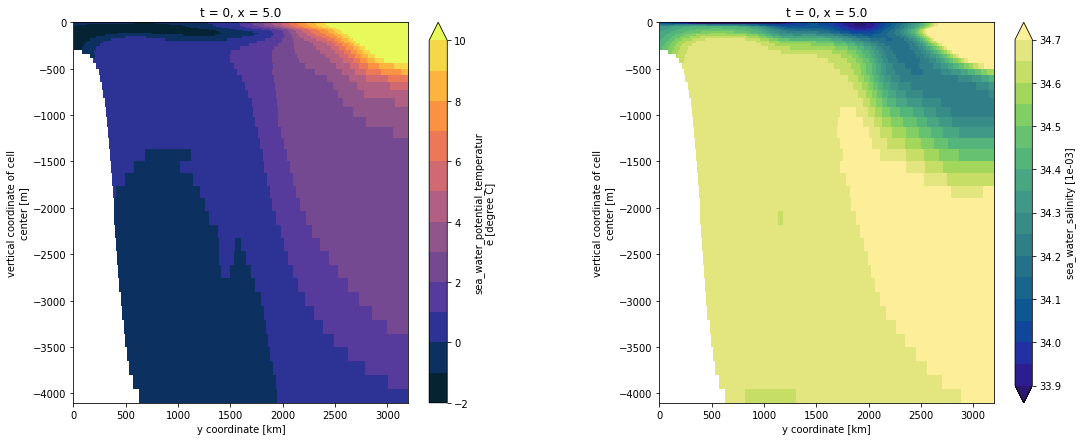

In [9]:
i_cond = xr.open_dataset("MITgcm_config/" + setup + "/" + confi + "/input/" 
                         + setup + "-" + confi + "-woa18_temperature_and_salinity_3D.nc")
fig, axes = plt.subplots(ncols=2, figsize=(18, 7))
levels_t = np.arange(-2, 11)
i_cond.temperature.where(i_cond.z >= bathy.bathy).isel(t=0, x=0).plot(ax=axes[0], cmap=cmo.thermal, levels=levels_t)
levels_s = np.arange(33.9, 34.7, 0.05)
i_cond.salinity.where(i_cond.z >= bathy.bathy).isel(t=0, x=0).plot(ax=axes[1], cmap=cmo.haline, levels=levels_s)
plt.subplots_adjust(wspace=0.4)

*Fig. 3: Initial conditions for the configuration. Left: temperature and right: salinity. Only one "longitude" is shown as the initial conditions are zonally constant*

Restoring of temperature and salinity values towards the initial conditions is applied in a sponge layer at the northern boundary (everywhere except for the surface grid cell) as defined in the mask created in this [Notebook](MITgcm_config/ESII_SO/RCSI100.L55_ctlv30_030W/input/create_bathymetry.ipynb). Where the mask is `1`, full restoring with a relaxation time scale of `1` month is applied, where the mask is $<1$ and $>0$, just the fraction of restoring as indicated by the value of the mask is applied. No restoring is applied where the mask is `0`.

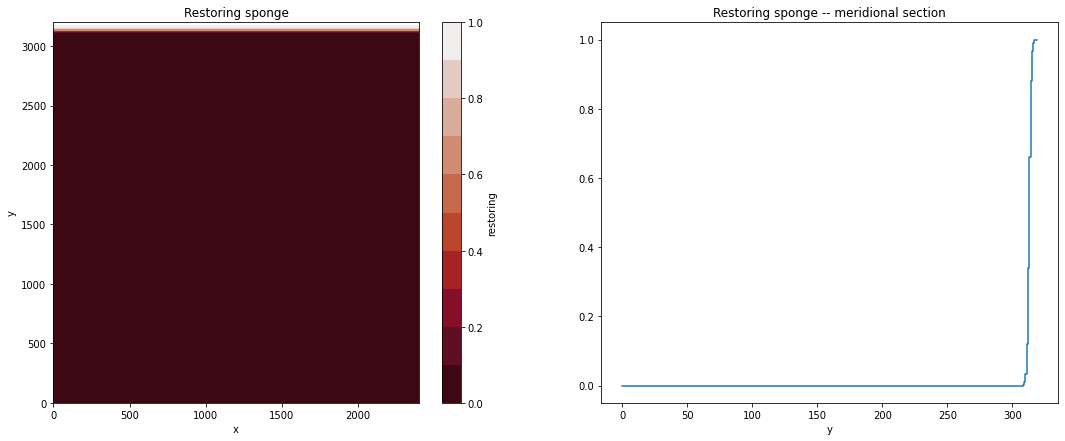

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 7))

levels = np.arange(0, 1.01, 0.1)
bathy.restoring_mask_with_sponge.isel(t=0, z=1).plot(levels=levels, cmap=cmo.amp_r, cbar_kwargs={'label': 'restoring'}, ax=axs[0])
axs[0].set_title("Restoring sponge")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

axs[1].step(np.arange(0, len(bathy.y)), bathy.restoring_mask_with_sponge[0, 1, :, 0], where="post")
axs[1].set_title("Restoring sponge -- meridional section")
axs[1].set_xlabel("y");

*Fig. 4: The restoring sponge layer used in the configuration. Where the mask is `1`, full restoring with a relaxation time scale of `1` month is applied, where the mask is $<1$ and $>0$, just the fraction of restoring as indicated by the value of the mask is applied. No restoring is applied where the mask is `0`.*

---

### __Atmospheric Forcing and Runoff__

The atmospheric forcing is taken from the [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) reanalysis by the [ECMWF](https://www.ecmwf.int/). Data from the same region as for the initial conditions are used ($30 ^{\circ} W$, $75 ^{\circ} S$ - $35 ^{\circ} S$). The hourly ERA5 fields from 1991 are sub-sampled to a 3-hourly temporal resolution and linearly interpolated to the 320 model grid points in the y-direction, with the model grid point at `y=0` corresponding to $75 ^{\circ} S$ and the grid point at `y=319` to $35 ^{\circ} S$. In cases where the meridional locations of the constructed grid do not coincide with the meridional locations of ERA5's grid, the ERA5 data are linearly interpolated to the new grid. The zonal section at $30 ^{\circ} W$ is then repeated $x$ times in the zonal direction in order to get a two-dimensional, zonally invariant forcing field, $x=240$ is the number of grid cells in x-direction. Please refer to [this notebook](MITgcm_config/ESII_SO/RCSI100.L55_ctlv30_030W/input/create_forcing.ipynb) for details on the preparation of the atmospheric forcing.

The methodology described above is applied to the following variables:  
* __air temperature__ at 2m (`t2m`)
* __zonal wind__ at 10m (`u10`)
* __meridional wind__ at 10m (`v10`)
* total __precipitation__ (`tp`)
    * Needs to be converted from m/hour to m/s
* downward __shortwave radiation__ (`ssrd`)
    * Needs to be converted from J/m$^2$/hour to W/m$^2$
* downward __longwave radiation__ (`strd`)
    * Needs to be converted from J/m$^2$/hour to W/m$^2$  

__Specific humidity__ (`q`) is not provided in the `ERA5` dataset at the surface. Thus specific humidity is calculated based on the 2m air temperature `t2m` and a constant relative humidity of 70% as done previously by [Gupta et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020JC016404). The constants used for the conversion are taken from the [`EXF`](https://mitgcm.readthedocs.io/en/latest/phys_pkgs/exf.html#run-time-parameters) package used to supply the atmospheric forcing to the ocean component of the MITgcm.  

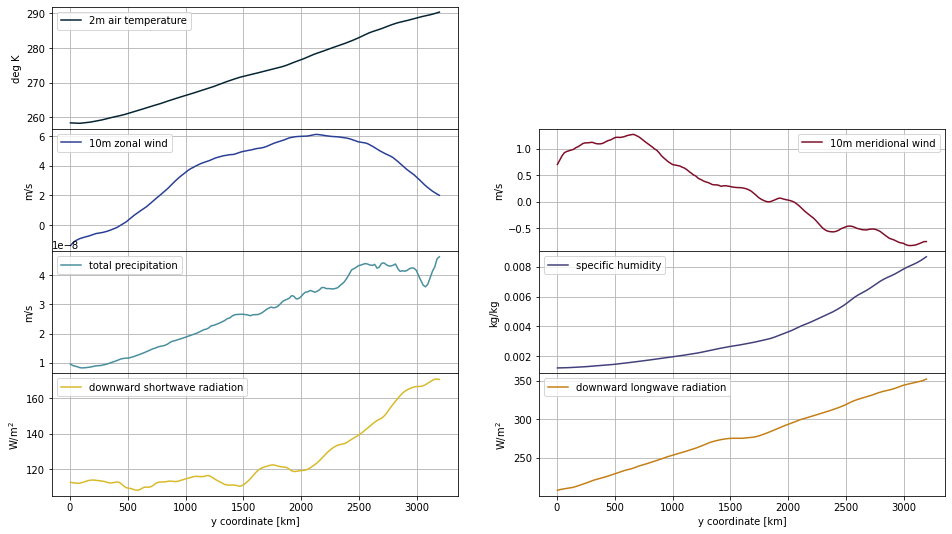

In [11]:
ds_forcing = xr.open_dataset("MITgcm_config/" + setup + "/" + confi + "/input/" 
                             + setup + "-" + confi + "-era5-atmospheric_forcing.nc")

fig, axes = plt.subplots(4, 2, figsize=(16, 9), sharex=True, gridspec_kw={'hspace': 0})

ds_forcing.temperature.isel(x=0).mean("time").plot(ax=axes[0, 0], label="2m air temperature", color=cmo.thermal(0./6.))
axes[0, 0].grid()
axes[0, 0].set_title("")
axes[0, 0].set_ylabel("deg K")
axes[0, 0].legend()

axes[0, 1].axis("off")

ds_forcing.zonal_wind.isel(x=0).mean("time").plot(ax=axes[1, 0], label="10m zonal wind", color=cmo.balance(0.1))
axes[1, 0].grid()
axes[1, 0].set_title("")
axes[1, 0].set_ylabel("m/s")
axes[1, 0].legend()

ds_forcing.meridional_wind.isel(x=0).mean("time").plot(ax=axes[1, 1], label="10m meridional wind", color=cmo.balance(0.9))
axes[1, 1].grid()
axes[1, 1].set_title("")
axes[1, 1].set_ylabel("m/s")
axes[1, 1].legend()

ds_forcing.precipitation.isel(x=0).mean("time").plot(ax=axes[2, 0], label="total precipitation", color=cmo.deep(0.5))
axes[2, 0].grid()
axes[2, 0].set_title("")
axes[2, 0].set_ylabel("m/s")
axes[2, 0].legend()

ds_forcing.specific_humidity.isel(x=0).mean("time").plot(ax=axes[2, 1], label="specific humidity", color=cmo.deep(0.8))
axes[2, 1].grid()
axes[2, 1].set_title("")
axes[2, 1].set_ylabel("kg/kg")
axes[2, 1].legend()

ds_forcing.downward_shortwave.isel(x=0).mean("time").plot(ax=axes[3, 0], label="downward shortwave radiation", color=cmo.solar(0.8))
axes[3, 0].grid()
axes[3, 0].set_title("")
axes[3, 0].set_ylabel("W/m$^2$")
axes[3, 0].legend()

ds_forcing.downward_longwave.isel(x=0).mean("time").plot(ax=axes[3, 1], label="downward longwave radiation", color=cmo.solar(0.6))
axes[3, 1].grid()
axes[3, 1].set_title("")
axes[3, 1].set_ylabel("W/m$^2$")
axes[3, 1].legend();

*Fig. 5: The annual mean of the atmospheric forcing for the configuration. Left panel shows (from top to bottom) 2m air temperature, 10m zonal wind, total precipitation, and downward shortwave radiation; right panel shows (from top to bottom) 10m meridional wind, specific humidity, and downward longwave radiation.*

__Runoff__ is estimated based on calving fluxes and basal melt rates reported by [Depoorter et al. (2013)](https://www.nature.com/articles/nature12567). They estimate a total runoff of 2775 Gt/year for Antarctica. Taking into account the total length of the 75$^{\circ}$S parallel is approximately 10405 km, the runoff per km of "coastline" is 0.267 Gt/year. We take the 75$^{\circ}$S parallel as an approximation to the Antarctic coastline as it is exactly that in our simulation. The length of the coastline in this configuration is 2400 km, so that we estimate a runoff of ~641 Gt/year for our configuration (equivalent to ~22173 m$^{3}$/s, assuming an ice density of 916.7 kg/m$^{3}$).  
This runoff is distributed among the surface near-shore grid cells of the domain as illustrated below. Liquid runoff from Antarctica is neglected. Note that the runoff does not have a seasonal cycle, i.e. the runoff of Antarctica is assumed to be constant throughout the year. 

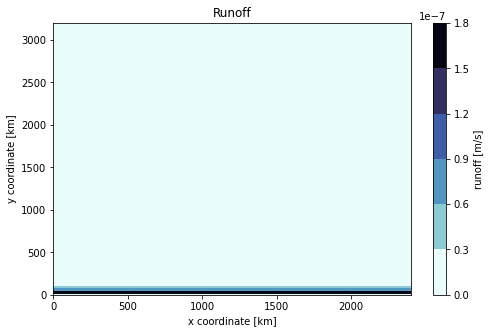

In [12]:
plt.figure(figsize=(8,5))
ds_forcing.runoff.plot(cmap=cmo.ice_r, levels=7)
plt.title("Runoff");

*Fig. 6: The distribution of runoff to the coastal grid cells of the configuration.*

---

### __Runtime Parameters__
All runtime parameters can be found [here](https://github.com/jk-rieck/2024-eddy-heat-transport-towards-sea-ice/tree/main/MITgcm_config/ESII_SO/RCSI100.L55_ctlv30_030W/input) in the respective files. The parameters specific to this configuration (that are not default values) are listed in the tables below.  

__`data`__:
 
| parameter           | value                                        | comment                                                                           |
| :-                  | :-                                           | :-                                                                                |
|------------------------------------|----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| __PARM01__          |                            |                                                                                                     |
| hFacMinDr           | 5.                         | set minimum partial cell size to 5 m                                                                |
| hFacMin             | 0.1                        | set minimum partial cell to 10 % of full cell                                                       |
| eosType             | 'JMD95Z'                   | modified version of the UNESCO equation of state                                                    |
| f0                  | -1.405e-4                  | f0 and beta are chosen as such that the model's beta plane starts at 75 degree South (f0)  and      |
| beta                | 1.145e-11                  | the beta value is taken from 55 degrees South, i.e. the meridional center of the domain             |
| tempAdvScheme       | 80                         | see [Choices of Parameters - Details](#choices) for details on schemes, viscosity, and diffusivity  |
| saltAdvScheme       | 80                         | see [Choices of Parameters - Details](#choices) for details on schemes, viscosity, and diffusivity  |
| viscA4              | 2.6E10                     | see [Choices of Parameters - Details](#choices) for details on schemes, viscosity, and diffusivity  |
| viscAr              | 1.0E-5                     | see [Choices of Parameters - Details](#choices) for details on schemes, viscosity, and diffusivity  |
| implicitViscosity   | .TRUE.                     | calculating the viscosity implicitely makes it unconditionally stable                               |
| diffKhT             | 0.                         | see [Choices of Parameters - Details](#choices) for details on schemes, viscosity, and diffusivity  |
| diffKrT             | 1.E-5                      | see [Choices of Parameters - Details](#choices) for details on schemes, viscosity, and diffusivity  |
| diffKhS             | 0.                         | see [Choices of Parameters - Details](#choices) for details on schemes, viscosity, and diffusivity  |
| diffKrS             | 1.E-5                      | see [Choices of Parameters - Details](#choices) for details on schemes, viscosity, and diffusivity  |
| implicitDiffusion   | .TRUE.                     | see [Choices of Parameters - Details](#choices) for details on schemes, viscosity, and diffusivity  |
| bottomDragQuadratic | 5.0E-2                     | choose large bottom drag to balance strong mean flow over lat bottom topography                      
| __PARM03__          |                            |                                                                                                     |
| deltaT              | 1200.0                     | model runs with a surprisingly large deltaT...                                                      |
| forcing_In_AB       | .FALSE.                    | because forcing is high frequency we don't use Adams-Bashforth extrapolation on it                  |
| momDissip_In_AB     | .FALSE.                    | needs to be switched off for stability of viscosity scheme                                          |
| __PARM04__          |                            |                                                                                                     |
| delX                | 240*10.E3                  | 240 grid cells in x direction of size 10 km                                                         |
| delY                | 320*10.E3                  | 320 grid cells in y direction of size 10 km                                                         |
| delR                | [...]                      | see section vertical grid above                                                                     |    
| interDiffKr_pCell   | .TRUE.                     | take into account partial cells in vertical diffusivity                                             |
| interViscAr_pCell   | .TRUE.                     | take into account partial cells in vertical viscosity                                               |
---

__`data.exf`__:

| parameter         | value                                          | comment                                                                           |
| :-                | :-                                             | :-                                                                                |
|------------------------------------|----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| __EXF_NML_01__    |                                                |                                                                                   |
| useExfCheckRange  | .FALSE.                                        | there is some problem with the temperature range when using `EXF` with `SEAICE`   |
| repeatPeriod      | 31104000.                                      | repeat forcing every 1 year, i.e. repeated year forcing                           | 
| __EXF_NML_02__    |                                                |                                                                                   |
| *var*period       | 10800.                                         | three hourly forcing input, *var* are the forcing variables, except runoff        |
| runoffperiod      | 31104000.                                      | yearly mean value for runoff                                                      |
---

__`data.kpp`__:

| parameter         | value                                          | comment                                                                           |
| :-                | :-                                             | :-                                                                                |
|------------------------------------|----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| __KPP_PARM01__    |                                                |                                                                                    |
| no non-default settings | | |
---


__`data.rbcs`__:

| parameter         | value                                          | comment                                                                           |
| :-                | :-                                             | :-                                                                                |
|------------------------------------|----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| __RBCS_PARM01__   |                                                |                                                                                   |
| rbcsForcingPeriod | 2592000.                                       | restoring comes from monthly mean values                                          |
| rbcsForcingCycle  | 31104000.                                      | restoring repeats every year                                                      |
| useRBCtemp        | .TRUE.                                         | use restoring of temperature                                                      |
| useRBCsalt        | .TRUE.                                         | use restoring of salinity                                                         |
| tauRelaxT         | 2592000.                                        | restoring timescale for temperature (one month)                                     |
| tauRelaxS         | 2592000.                                        | restoring timescale for salinity (one month)                                        |
---

__`data.seaice`__:

| parameter         | value                                          | comment                                                                           |
| :-                | :-                                             | :-                                                                                |
|------------------------------------|----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| __SEAICE_PARM01__ |                                                |                                                                                   |  
| usePW79thermodynamics | .TRUE.                                     | not using THSICE |
| SEAICEpressReplFac    | 0.                                         | based on recommendations by M. Losch in MITgcm support mailing list               |    
| SEAICE_strength       | 2.299e+04                                  | based on [Ungermann et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012128) |  
| SEAICE_eccen          | 1.523                                      | based on [Ungermann et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012128) |
| SEAICE_cStar          | 15.92                                      | based on [Ungermann et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012128) |
| SEAICE_dryIceAlb      | 0.71                                       | based on [Ungermann et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012128) |
| SEAICE_wetIceAlb      | 0.7119                                     | based on [Ungermann et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012128) |
| SEAICE_drySnowAlb     | 0.8556                                     | based on [Ungermann et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012128) |
| SEAICE_wetSnowAlb     | 0.7903                                     | based on [Ungermann et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012128) |
| SEAICE_drag           | 1.657e-03                                  | based on [Ungermann et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012128) |
| SEAICE_waterDrag      | 6.647e-03                                  | based on [Ungermann et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012128) |  
| H0                    | 0.5649                                     | based on [Ungermann et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012128) |  
| SEAICE_deltaMin       | 1.e-10                                     | based on recommendations by D. Ringeisen, pers. communication                     |  
| SEAICEetaZmethod      | 3                                          | based on recommendations by D. Ringeisen, pers. communication                     |  
| LSR_ERROR             | 1.E-6                                      | based on recommendations by D. Ringeisen, pers. communication                     |  
| SEAICElinearIterMax   | 500                                        | based on recommendations by M. Losch in MITgcm support mailing list               |  
| SEAICEnonLinIterMax   | 10                                         | based on recommendations by M. Losch in MITgcm support mailing list               |  
| SEAICE_no_Slip        | .TRUE.                                     | with free slip ice moves very fast zonally through the periodic domain            |  
---

__`data.salt_plume`__

| parameter         | value                                          | comment                                                                           |
| :-                | :-                                             | :-                                                                                |
|------------------------------------|----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| __SALT_PLUME_PARM01__ |                                            |                                                                                   |
| SaltPlumeCriterion    | 0.03                                       | weaker than default to not inject brine too deep                                  |
| PlumeMethod           | 5                                          | dump salt at top of water column|
---

__`data.layers`__

| parameter             | value                                           | comment                                                                           |
| :-                    | :-                                              | :-                                                                                |
|------------------------------------|----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| __LAYERS_PARM01__     |                                                 |                                                                                   |
| layers_name(1)        | 'RHO'                                           | construct layers based on density                                                 |
| layers_krho(1)        | 41                                              | use potential density ref. to layer 41 in calculations of the LAYERS package  |
| layers_bounds(1:56,1) | 33.0  , 33.5  , 34.0  , 34.5  ,                 | unequally spaced layers chosen to resolve the                                     |
|                       | 35.0  , 35.25 , 35.5  , 35.75 ,                 | weak stratification in the deeper ocean                                           |
|                       | 36.0  , 36.1  , 36.2  , 36.3  , 36.4  , 36.5  , ||
|                       | 36.55 , 36.6  , 36.65 , 36.7  , 36.75 , 36.8  , 36.85 , ||
|                       | 36.9  , 36.92 , 36.94 , 36.96 , 36.98 , 37.0  , 37.02 , 37.04 , 37.06 , 37.08, 37.1  , 37.12 , 37.14, ||
|                       | 37.16 , 37.17 , 37.18 , 37.19 , 37.2  , 37.21 , 37.22 , 37.23 , 37.24 , ||
|                       | 37.25 , 37.3  , 37.35 ,                         ||
|                       | 37.4  , 37.45 , 37.5  , 37.55  ,                ||
|                       | 37.6  , 37.7  , 37.8  , 37.9  , 38.0  , 38.1,   ||

---

### __Choices of Parameters - Details__
<a id="choices"></a>

There are two main areas, where the choice of parameters is not straightforward: 1. advection scheme, viscosity, and diffusivity, 2. vertical mixing 

The choices made in these three categories and the processes and sensitivity studies leading to these choices are detailed in this section.

#### __1. Advection scheme, viscosity, and diffusivity__

A second-order moment [Prather (1986)](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/JD091iD06p06671) scheme is used for tracer advection as suggested by [Hill et al. (2012)](https://www.sciencedirect.com/science/article/pii/S1463500311001880?via%3Dihub) to reduce spurious diapycnal mixing in eddying reentrant channel configurations.  

A biharmonic __viscosity__ parameterization is implemented. The biharmonic is chosen over the harmonic as it restricts the dissipation to scales closer to the grid scale. A simple biharmonic viscosity is prefered over Leith or Smagorinsky viscosities as it is more straightforward to estimate a range of potential viscosities that work in the configuration and thus less effort is needed to find the right value for the parameterization.  

Horizontal tracer __diffusivity__ is set to zero. This does not mean that there is no diffusivity, as numerical diffusivity by the advection scheme is inevitable. We thus just keep the total diffusivity as small as possible, by not implementing any additional parameterized diffusivity.

#### __2. Vertical mixing__

Vertical mixing is crucial for a study that investigates the impact of eddies on sea ice as it is mostly vertical processes that can bring heat towards the ice. Thus we use the KPP package to parameterize mixing in the surface bounday layer. The general vertical diffusivity is set to `1.0E-5` which is within the range of observed mean value for the open ocean.


---

### __Results__

This section includes a collection of standard plots created from the output of the configuration described above. These standard plots include sections of temperature, salinity and density, sea ice area and thickness, zonal transport, meridional overturning streamfunctions etc.  
We also will save the pre-processed data used for creating these plots to netcdf-files so that the plots can be re-created later on or the data can be used in comparing to other simulations. The pre-processing and saving will only be performed if the files are not yet present.

In [ ]:
import postmit as pm
import glob
import xgcm
import xarray as xr

if ((glob.glob('summary_diags/summary_timeseries.nc') != [])
    & (glob.glob('summary_diags/summary_climatology.nc') != [])):
    ds_ts = xr.open_dataset('summary_diags/summary_timeseries.nc')
    ds_cl = xr.open_dataset('summary_diags/summary_climatology.nc')
else:
    # create timeseries from yearly output
    ds_y = pm.checks.apply_all_checks(xr.open_zarr('run/zarr_Diags/output.1y.zarr/'), path_to_input="input/")
    ds_y["oceFWflx"] = ds_y["SIempmr"]
    ds_ts = xr.Dataset(coords=ds_y.coords)
    for i in ds_ts.coords:
        if ((i != "XC") & (i != "XG")):
            if "XC" in ds_ts[i].dims:
                ds_ts[i] = ds_ts[i].mean("XC")
            elif "XG" in ds_ts[i].dims:
                ds_ts[i] = ds_ts[i].mean("XG")
    ds_ts = ds_ts.mean(("XC", "XG"))
    metrics = {
            ('X'): ['dxC', 'dxG', 'dxF', 'dxV'], # X distances
            ('Y'): ['dyC', 'dyG', 'dyF', 'dyU'], # Y distances
            ('Z'): ['drF', 'drW', 'drS', 'drC'], # Z distances
            ('X', 'Y'): ['rAw', 'rAs', 'rA', 'rAz'] # Areas in x-y plane
            }
    grid = xgcm.Grid(ds_y, periodic=["X", "Y"], metrics=metrics)
    ds_ts = ds_ts.assign(variables={"SALT_zonal_mean": (('time', 'Z', 'YC'), ds_y.SALT.mean("XC")),
                                    "THETA_zonal_mean": (('time', 'Z', 'YC'), ds_y.THETA.mean("XC")),
                                    "UVEL_zonal_mean": (('time', 'Z', 'YC'), ds_y.UVEL.mean("XG")),
                                    "VVEL_zonal_mean": (('time', 'Z', 'YG'), ds_y.VVEL.mean("XC")),
                                    "MOC_zonal_mean": (('time', 'Z', 'YG'), pm.calcs.total_MOC(ds_y).MOC),
                                    "MOC_res_zonal_mean": (('time', 'layer_center', 'YG'), pm.calcs.residual_MOC(ds_y, path_to_input="input/").MOC_res),
                                    "MOC_res_z_zonal_mean": (('time', 'Z', 'YG'), pm.calcs.residual_MOC(ds_y, path_to_input="input/").MOC_res_z),
                                    "MXLDEPTH_zonal_mean": (('time', 'YC'), ds_y.MXLDEPTH.mean("XC")),
                                    "ETAN_zonal_mean": (('time', 'YC'), ds_y.ETAN.mean("XC")),
                                    "SIarea_zonal_mean": (('time', 'YC'), ds_y.SIarea.mean("XC")),
                                    "SIheff_zonal_mean": (('time', 'YC'), ds_y.SIheff.mean("XC")),
                                    "SIuice_zonal_mean": (('time', 'YC'), ds_y.SIuice.mean("XG")),
                                    "SIvice_zonal_mean": (('time', 'YG'), ds_y.SIvice.mean("XC")),
                                    "BFlx_SURF_zonal_mean": (('time', 'YG'), pm.calcs.surface_buoy_flux(ds_y, path_to_input="input/", 
                                                                                                        latmin=-75, latmax=-35, lonmin=-30, lonmax=-30).BFlx_SURF.mean("XC")),
                                    "SALT_domain_ave": (('time'), (grid.integrate(ds_y.SALT, "Z") / ds_y.Depth).mean(("YC", "XC"))),
                                    "THETA_domain_ave": (('time'), (grid.integrate(ds_y.THETA, "Z") / ds_y.Depth).mean(("YC", "XC"))),
                                    "UTRANS": (('time'), pm.calcs.transports(ds_y).UTRANS),
                                    "UTRANSbaro": (('time'), pm.calcs.transports(ds_y).UTRANSbaro),
                                    "KE_domain_ave": (('time'), (grid.integrate(0.5 * (grid.interp(ds_y.UVEL ** 2., "X") 
                                                                                       + grid.interp(ds_y.VVEL ** 2., "Y")), "Z") / ds_y.Depth).mean(("YC", "XC"))),
                                    "KEx_domain_ave": (('time'), (grid.integrate((grid.interp(ds_y.UVEL ** 2., "X")), "Z") / ds_y.Depth).mean(("YC", "XC")))})
    ds_ts.to_netcdf("summary_diags/summary_timeseries.nc")
    # create climatology from monthly output of that last 10 years of the simulation (or less if less than 10 years are available)
    ds_m = pm.checks.apply_all_checks(xr.open_zarr('run/zarr_Diags/output.1m.zarr/'), path_to_input="input/")
    ds_m = ds_m.isel(time=slice(len(ds_m.time)-(10 * 12), len(ds_m.time)))
    ds_m["oceFWflx"] = ds_m["SIempmr"]
    ds_cl = xr.Dataset(coords=ds_m.coords)
    for i in ds_cl.coords:
        if ((i != "XC") & (i != "XG")):
            if "XC" in ds_cl[i].dims:
                ds_cl[i] = ds_cl[i].mean("XC")
            elif "XG" in ds_cl[i].dims:
                ds_cl[i] = ds_cl[i].mean("XG")
    ds_cl = ds_cl.mean(("XC", "XG")).groupby("time.month").mean("time")
    metrics = {
            ('X'): ['dxC', 'dxG', 'dxF', 'dxV'], # X distances
            ('Y'): ['dyC', 'dyG', 'dyF', 'dyU'], # Y distances
            ('Z'): ['drF', 'drW', 'drS', 'drC'], # Z distances
            ('X', 'Y'): ['rAw', 'rAs', 'rA', 'rAz'] # Areas in x-y plane
            }
    grid = xgcm.Grid(ds_m, periodic=["X", "Y"], metrics=metrics)
    ds_cl = ds_cl.assign(variables={"SALT_zonal_mean": (('month', 'Z', 'YC'), ds_m.SALT.mean("XC").groupby("time.month").mean("time")),
                                    "THETA_zonal_mean": (('month', 'Z', 'YC'), ds_m.THETA.mean("XC").groupby("time.month").mean("time")),
                                    "UVEL_zonal_mean": (('month', 'Z', 'YC'), ds_m.UVEL.mean("XG").groupby("time.month").mean("time")),
                                    "VVEL_zonal_mean": (('month', 'Z', 'YG'), ds_m.VVEL.mean("XC").groupby("time.month").mean("time")),
                                    "MOC_zonal_mean": (('month', 'Z', 'YG'), pm.calcs.total_MOC(ds_m).MOC.groupby("time.month").mean("time")),
                                    "MOC_res_zonal_mean": (('month', 'layer_center', 'YG'), 
                                                           pm.calcs.residual_MOC(ds_m, path_to_input="input/").MOC_res.groupby("time.month").mean("time")),
                                    "MOC_res_z_zonal_mean": (('month', 'Z', 'YG'), 
                                                             pm.calcs.residual_MOC(ds_m, path_to_input="input/").MOC_res_z.groupby("time.month").mean("time")),
                                    "MXLDEPTH_zonal_mean": (('month', 'YC'), ds_m.MXLDEPTH.mean("XC").groupby("time.month").mean("time")),
                                    "ETAN_zonal_mean": (('month', 'YC'), ds_m.ETAN.mean("XC").groupby("time.month").mean("time")),
                                    "SIarea_zonal_mean": (('month', 'YC'), ds_m.SIarea.mean("XC").groupby("time.month").mean("time")),
                                    "SIheff_zonal_mean": (('month', 'YC'), ds_m.SIheff.mean("XC").groupby("time.month").mean("time")),
                                    "SIuice_zonal_mean": (('month', 'YC'), ds_m.SIuice.mean("XG").groupby("time.month").mean("time")),
                                    "SIvice_zonal_mean": (('month', 'YG'), ds_m.SIvice.mean("XC").groupby("time.month").mean("time")),
                                    "BFlx_SURF_zonal_mean": (('month', 'YG'), 
                                                             pm.calcs.surface_buoy_flux(ds_m, path_to_input="input/", 
                                                                                        latmin=-75, latmax=-35, 
                                                                                        lonmin=-30, lonmax=-30).BFlx_SURF.mean("XC").groupby("time.month").mean("time")),
                                    "SALT_domain_ave": (('month'), (grid.integrate(ds_m.SALT, "Z") / ds_m.Depth).mean(("YC", "XC")).groupby("time.month").mean("time")),
                                    "THETA_domain_ave": (('month'), (grid.integrate(ds_m.THETA, "Z") / ds_m.Depth).mean(("YC", "XC")).groupby("time.month").mean("time")),
                                    "UTRANS": (('month'), pm.calcs.transports(ds_m).UTRANS.groupby("time.month").mean("time")),
                                    "UTRANSbaro": (('month'), pm.calcs.transports(ds_m).UTRANSbaro.groupby("time.month").mean("time")),
                                    "KE_domain_ave": (('month'), (grid.integrate(0.5 * (grid.interp(ds_m.UVEL ** 2., "X") 
                                                                                       + grid.interp(ds_m.VVEL ** 2., "Y")), "Z") / ds_m.Depth).mean(("YC", "XC")).groupby("time.month").mean("time")),
                                    "KEx_domain_ave": (('month'), (grid.integrate((grid.interp(ds_m.UVEL ** 2., "X")), "Z") / ds_m.Depth).mean(("YC", "XC")).groupby("time.month").mean("time"))})
    ds_cl.to_netcdf("summary_diags/summary_climatology.nc")

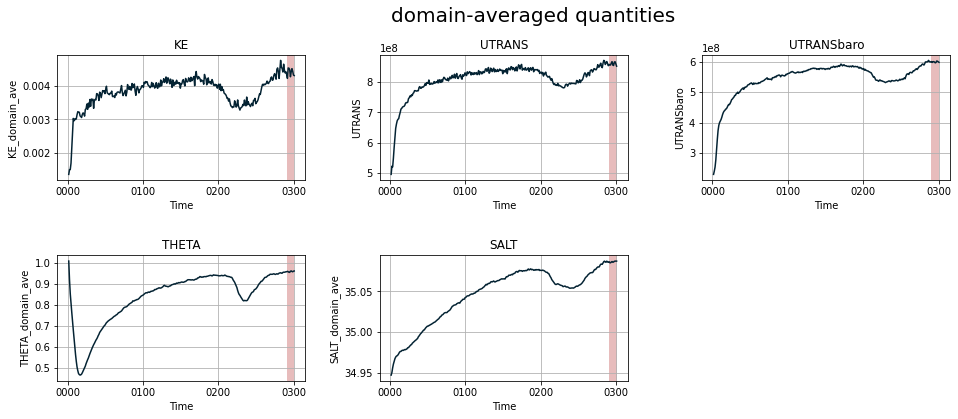

In [11]:
from matplotlib.patches import Rectangle
minus10 = ds_ts.time.isel(time=-11).values
delta10 = ds_ts.time.isel(time=-1).values - ds_ts.time.isel(time=-11).values

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16, 6))
ds_ts.KE_domain_ave.plot(ax=ax[0, 0], color=cmo.thermal(0./6.))
ax[0, 0].grid()
ax[0, 0].set_title("KE")
ax[0, 0].add_patch(Rectangle((minus10, ax[0, 0].get_ylim()[0]), delta10, 
                             ax[0, 0].get_ylim()[1] - ax[0, 0].get_ylim()[0], alpha=0.3, facecolor="firebrick"))
ds_ts.UTRANS.plot(ax=ax[0, 1], color=cmo.thermal(0./6.))
ax[0, 1].grid()
ax[0, 1].set_title("UTRANS")
ax[0, 1].add_patch(Rectangle((minus10, ax[0, 1].get_ylim()[0]), delta10, 
                             ax[0, 1].get_ylim()[1] - ax[0, 1].get_ylim()[0], alpha=0.3, facecolor="firebrick"))
ds_ts.UTRANSbaro.plot(ax=ax[0, 2], color=cmo.thermal(0./6.))
ax[0, 2].grid()
ax[0, 2].set_title("UTRANSbaro")
ax[0, 2].add_patch(Rectangle((minus10, ax[0, 2].get_ylim()[0]), delta10, 
                             ax[0, 2].get_ylim()[1] - ax[0, 2].get_ylim()[0], alpha=0.3, facecolor="firebrick"))
ds_ts.THETA_domain_ave.plot(ax=ax[1, 0], color=cmo.thermal(0./6.))
ax[1, 0].grid()
ax[1, 0].set_title("THETA")
ax[1, 0].add_patch(Rectangle((minus10, ax[1, 0].get_ylim()[0]), delta10, 
                             ax[1, 0].get_ylim()[1] - ax[1, 0].get_ylim()[0], alpha=0.3, facecolor="firebrick"))
ds_ts.SALT_domain_ave.plot(ax=ax[1, 1], color=cmo.thermal(0./6.))
ax[1, 1].grid()
ax[1, 1].set_title("SALT")
ax[1, 1].add_patch(Rectangle((minus10, ax[1, 1].get_ylim()[0]), delta10, 
                             ax[1, 1].get_ylim()[1] - ax[1, 1].get_ylim()[0], alpha=0.3, facecolor="firebrick"))
fig.delaxes(ax[1, 2])
plt.subplots_adjust(hspace=0.6, wspace=0.3)
ax[0, 1].text(ds_ts.time.isel(time=0).values, 1.0e9, "domain-averaged quantities", fontsize=20);

*Fig. 7: Time series of yearly, domain-averaged, volume-weighted Kinetic Energy (KE), total zonal transport (UTRANS), baroclinic zonal transport (UTRANSbaro), temperature (THETA), and salinity (SALT). The red boxes indicate the 10 last years of the simulation that have been used to calculate the averages shown below.*

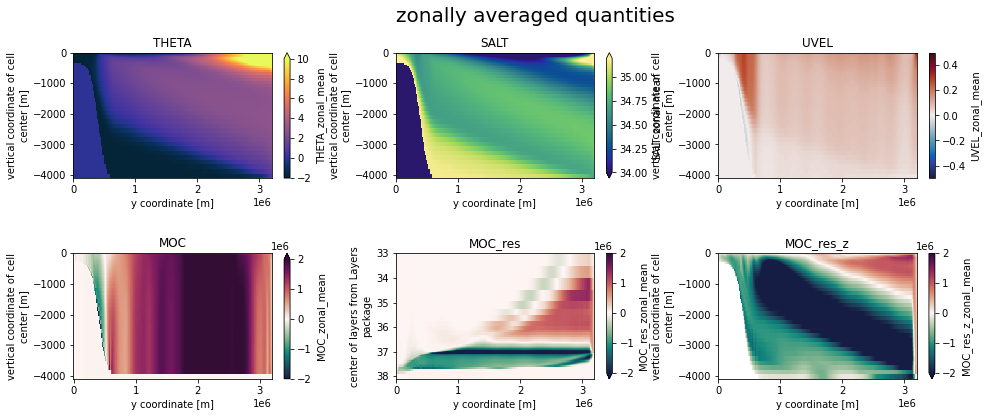

In [12]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16, 6))
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time))).THETA_zonal_mean.mean("time").plot(ax=ax[0, 0], vmin=-2.0, vmax=10, cmap=cmo.thermal)
ax[0, 0].set_title("THETA")
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time))).SALT_zonal_mean.mean("time").plot(ax=ax[0, 1], vmin=34.0, vmax=35.2, cmap=cmo.haline)
ax[0, 1].set_title("SALT")
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time))).UVEL_zonal_mean.mean("time").plot(ax=ax[0, 2], vmin=-0.5, vmax=0.5, cmap=cmo.balance)
ax[0, 2].set_title("UVEL")
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time))).MOC_zonal_mean.mean("time").plot(ax=ax[1, 0], vmin=-2.0e6, vmax=2.0e6, cmap=cmo.curl)
ax[1, 0].set_title("MOC")
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time))).MOC_res_zonal_mean.mean("time").plot(ax=ax[1, 1], vmin=-2.0e6, vmax=2.0e6, cmap=cmo.curl, yincrease=False)
ax[1, 1].set_title("MOC_res")
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time))).MOC_res_z_zonal_mean.mean("time").plot(ax=ax[1, 2], vmin=-2.0e6, vmax=2.0e6, cmap=cmo.curl)
ax[1, 2].set_title("MOC_res_z")
plt.subplots_adjust(hspace=0.6, wspace=0.3)
ax[0, 1].text(0, 1000, "zonally averaged quantities", fontsize=20);

*Fig. 8: Zonal averages over the last 10 years of the simulation of temperature (THETA), salinity (SALT), zonal velocity (UVEL), total meridional overturning circulation (MOC), residual meridional overturning circulation in density- (MOC_res) and depth-space (MOC_res_z).*

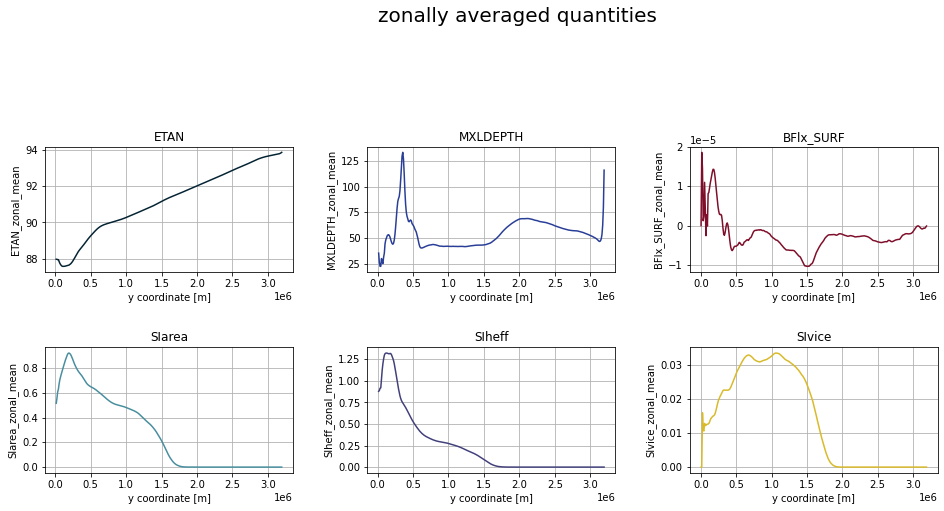

In [13]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16, 6))
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time)), YC=slice(1, None)).ETAN_zonal_mean.mean("time").plot(ax=ax[0, 0], color=cmo.thermal(0./6.))
ax[0, 0].grid()
ax[0, 0].set_title("ETAN")
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time)), YC=slice(1, None)).MXLDEPTH_zonal_mean.mean("time").plot(ax=ax[0, 1], color=cmo.balance(0.1))
ax[0, 1].grid()
ax[0, 1].set_title("MXLDEPTH")
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time)), YC=slice(1, None)).BFlx_SURF_zonal_mean.mean("time").plot(ax=ax[0, 2], color=cmo.balance(0.9))
ax[0, 2].grid()
ax[0, 2].set_title("BFlx_SURF")
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time)), YC=slice(1, None)).SIarea_zonal_mean.mean("time").plot(ax=ax[1, 0], color=cmo.deep(0.5))
ax[1, 0].grid()
ax[1, 0].set_title("SIarea")
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time)), YC=slice(1, None)).SIheff_zonal_mean.mean("time").plot(ax=ax[1, 1], color=cmo.deep(0.8))
ax[1, 1].grid()
ax[1, 1].set_title("SIheff")
ds_ts.isel(time=slice(len(ds_ts.time)-10, len(ds_ts.time)), YC=slice(1, None)).SIvice_zonal_mean.mean("time").plot(ax=ax[1, 2], color=cmo.solar(0.8))
ax[1, 2].grid()
ax[1, 2].set_title("SIvice")
plt.subplots_adjust(hspace=0.6, wspace=0.3)
ax[0, 1].text(0, 260, "zonally averaged quantities", fontsize=20);

*Fig. 9: Zonal averages over the last 10 years of the simulation of sea surface height (ETAN), mixed layer depth (MXLDEPTH), surface buoyancy flux (BFlx_SURF), sea ice area (SIarea), sea ice thickness (SIheff) and meridional velocity of sea ice (SIvice).*

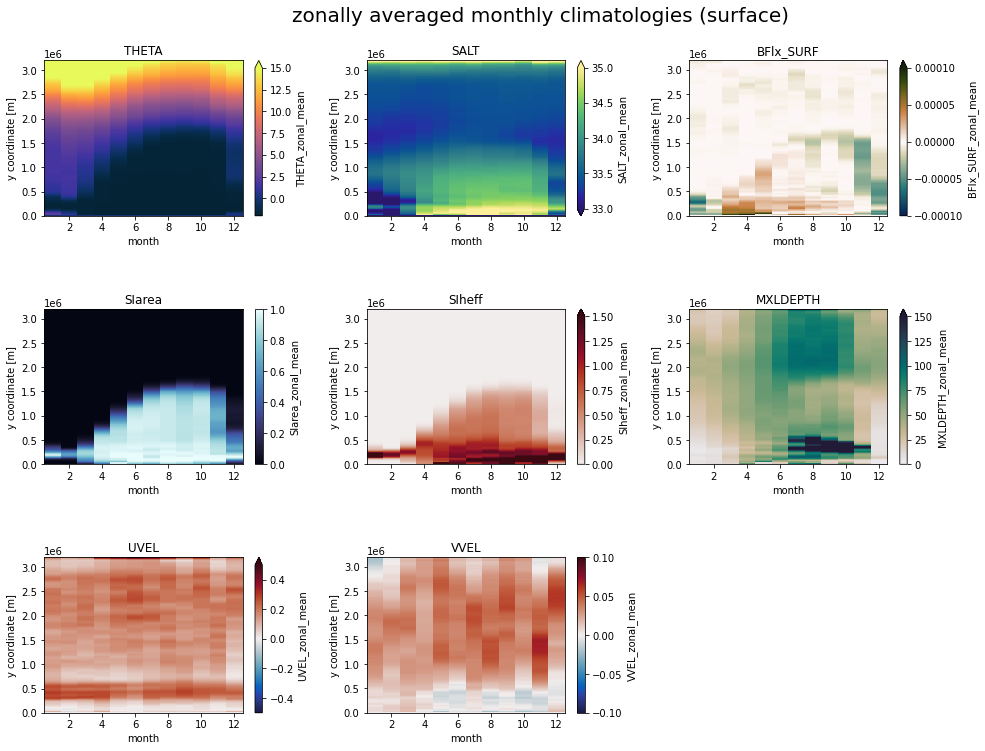

In [14]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(16, 12))
ds_cl.THETA_zonal_mean.sel(Z=0, method="nearest").plot(ax=ax[0, 0], vmin=-2.0, vmax=15, cmap=cmo.thermal, x="month")
ax[0, 0].set_title("THETA")
ds_cl.SALT_zonal_mean.sel(Z=0, method="nearest").plot(ax=ax[0, 1], vmin=33, vmax=35, cmap=cmo.haline, x="month")
ax[0, 1].set_title("SALT")
ds_cl.BFlx_SURF_zonal_mean.plot(ax=ax[0, 2], vmin=-1e-4, vmax=1e-4, cmap=cmo.tarn_r, x="month")
ax[0, 2].set_title("BFlx_SURF")
ds_cl.SIarea_zonal_mean.plot(ax=ax[1, 0], vmin=0, vmax=1, cmap=cmo.ice, x="month")
ax[1, 0].set_title("SIarea")
ds_cl.SIheff_zonal_mean.plot(ax=ax[1, 1], vmin=0, vmax=1.5, cmap=cmo.amp, x="month")
ax[1, 1].set_title("SIheff")
ds_cl.MXLDEPTH_zonal_mean.plot(ax=ax[1, 2], vmin=0, vmax=150, cmap=cmo.rain, x="month")
ax[1, 2].set_title("MXLDEPTH")
ds_cl.UVEL_zonal_mean.sel(Z=0, method="nearest").plot(ax=ax[2, 0], vmin=-0.5, vmax=0.5, cmap=cmo.balance, x="month")
ax[2, 0].set_title("UVEL")
ds_cl.VVEL_zonal_mean.sel(Z=0, method="nearest").plot(ax=ax[2, 1], vmin=-0.1, vmax=0.1, cmap=cmo.balance, x="month")
ax[2, 1].set_title("VVEL")
fig.delaxes(ax[2, 2])
plt.subplots_adjust(hspace=0.6, wspace=0.3)
ax[0, 1].text(-4, 4e6, "zonally averaged monthly climatologies (surface)", fontsize=20);

*Fig. 10: Zonally averaged surface monthly climatologies for the last 10 years of the simulation of temperature (THETA), salinity (SALT), surface buoyancy flux (BFlx_SURF), sea ice area (SIarea), sea ice thickness (SIheff), mixed layer depth (MXLDEPTH), zonal velocity (UVEL), and meridional velocity (VVEL).*

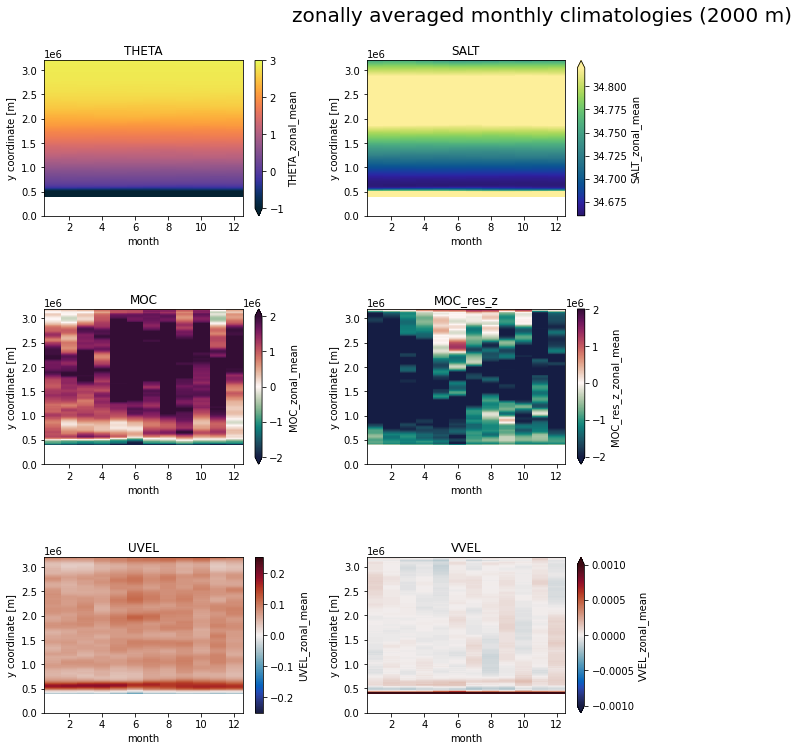

In [15]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(16, 12))
ds_cl.THETA_zonal_mean.where(ds_cl.maskC==1).sel(Z=-2000, method="nearest").plot(ax=ax[0, 0], vmin=-1.0, vmax=3, cmap=cmo.thermal, x="month")
ax[0, 0].set_title("THETA")
ds_cl.SALT_zonal_mean.where(ds_cl.maskC==1).sel(Z=-2000, method="nearest").plot(ax=ax[0, 1], vmin=34.66, vmax=34.82, cmap=cmo.haline, x="month")
ax[0, 1].set_title("SALT")
fig.delaxes(ax[0, 2])
ds_cl.MOC_zonal_mean.where(ds_cl.maskS==1).sel(Z=-2000, method="nearest").plot(ax=ax[1, 0], vmin=-2e6, vmax=2e6, cmap=cmo.curl, x="month")
ax[1, 0].set_title("MOC")
ds_cl.MOC_res_z_zonal_mean.where(ds_cl.maskS==1).sel(Z=-2000, method="nearest").plot(ax=ax[1, 1], vmin=-2e6, vmax=2e6, cmap=cmo.curl, x="month")
ax[1, 1].set_title("MOC_res_z")
fig.delaxes(ax[1, 2])
ds_cl.UVEL_zonal_mean.where(ds_cl.maskC==1).sel(Z=-2000, method="nearest").plot(ax=ax[2, 0], vmin=-0.25, vmax=0.25, cmap=cmo.balance, x="month")
ax[2, 0].set_title("UVEL")
ds_cl.VVEL_zonal_mean.where(ds_cl.maskS==1).sel(Z=-2000, method="nearest").plot(ax=ax[2, 1], vmin=-0.001, vmax=0.001, cmap=cmo.balance, x="month")
ax[2, 1].set_title("VVEL")
fig.delaxes(ax[2, 2])
plt.subplots_adjust(hspace=0.6, wspace=0.3)
ax[0, 1].text(-4, 4e6, "zonally averaged monthly climatologies (2000 m)", fontsize=20);

*Fig. 11: Zonally averaged 2000 m monthly climatologies for the last 10 years of the simulation of temperature (THETA), salinity (SALT), total meridional overturning circulation (MOC), residual meridional overturning circulation (MOC_res_z), zonal velocity (UVEL), and meridional velocity (VVEL).*

---

### __References__

&emsp;[__Boyer__, T. P., H. E. Garcia, R. A. Locarnini, M. M. Zweng, A. V. Mishonov, J. R. Reagan, K. A. Weathers, O. K. Baranova, C. R. Paver, D. Seidov and I. V. Smolyar (2018): World Ocean Atlas 2018. woa18_decav_t15_04.nc, woa18_decav_s15_04.nc. NOAA National Centers for Environmental Information. Dataset. https://www.ncei.noaa.gov/archive/accession/NCEI-WOA18. Accessed 02.02.2021.](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-WOA18)  

&emsp;[__Depoorter__, M. A., J. L. Bamber, J. A. Griggs, J. T. M. Lenaerts, S. R. M. Ligtenberg, M. R. van den Broeke and G. Moholdt (2013): Calving fluxes and basal melt rates of Antarctic ice shelves, *Nature*, __502__, 89-92, doi:10.1038/nature12567.](https://www.nature.com/articles/nature12567)

&emsp;[__Doddridge__, E. W., J. Marshall, H. Song, J.-M. Campin, M. Kelley and L. Nazarenko (2019): Eddy Compensation Dampens Southern Ocean Sea Surface Temperature Response to Westerly Wind Trends, *Geophysical Research Letters*, __46__, 4365-4377, doi:10.1029/2019GL082758.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL082758)  

&emsp;[__Gupta__, M., J. Marshall, H. Song, J.-M. Campin and G. Meneghello (2020): Sea-Ice Melt Driven by Ice-Ocean Stresses on the Mesoscale, *Journal of Geophysical Research: Oceans*, __125__, e2020JC016404, doi:10.1029/2020JC016404.](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020JC016404)

&emsp;[__Hill__, C., D. Ferreira, J.-M. Campin, J. Marshall, R. Abernathey and N. Barrier (2012): Controlling spurious diapycnal mixing in eddy-resolving height-coordinate ocean models – Insights from virtual deliberate tracer release experiments, *Ocean Modelling*, __45-46__, 14-26, doi:10.1016/j.ocemod.2011.12.001.](https://www.sciencedirect.com/science/article/pii/S1463500311001880?via%3Dihub)

&emsp;[__Locarnini__, R. A., A. V. Mishonov, O. K. Baranova, T. P. Boyer, M. M. Zweng, H. E. Garcia, J. R. Reagan, D. Seidov, K. Weathers, C. R. Paver, and I. Smolyar (2019): World Ocean Atlas 2018, Volume 1: Temperature. A. Mishonov Technical Ed.; NOAA Atlas NESDIS 81, 52 pp.](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-WOA18)

&emsp;[__Prather__, M. J. (1986): Numerical Advection by Conservation of Second-Order Moments, *Journal of Geophysical Research*, __91__, 6671-6681, doi:10.1029/JD091iD06p06671.](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/JD091iD06p06671)

&emsp;[__Stewart__, K. D., A. McC. Hogg, S. M. Griffies, A. P. Heerdegen, M. L. Ward, P. Spence and M. H. England (2017): Vertical resolution of baroclinic modes in global ocean models, *Ocean Modelling*, __113__, 50-65, doi:10.1016/j.ocemod.2017.03.012.](https://www.sciencedirect.com/science/article/abs/pii/S1463500317300434)  

&emsp;[__Ungermann__]()

&emsp;[__Zweng__, M. M., J. R. Reagan, D. Seidov, T. P. Boyer, R. A. Locarnini, H. E. Garcia, A. V. Mishonov, O. K. Baranova, K. Weathers, C. R. Paver, and I. Smolyar (2019): World Ocean Atlas 2018, Volume 2: Salinity. A. Mishonov Technical Ed.; NOAA Atlas NESDIS 82, 50 pp.](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-WOA18)



In [ ]:
%%capture
!jupyter nbconvert doc.ipynb --no-input --no-prompt --to markdown